# Here plot activity not averaged over time for each poke

In [773]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import seaborn
import pandas as pd
#import cv2
import scipy.optimize as op
import sys
import networkx as nx
import time
import matplotlib
import copy as cp
import scipy.ndimage as ndi 

import scipy as sp
import scipy.signal
seaborn.set(style='ticks',font_scale=1.5)


In [774]:
poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])

# From pycontrol

In [775]:
# Class for converting timestamps between recording systems using sync pulses with 
# random inter-pulse intervals. 
# https://pycontrol.readthedocs.io/en/latest/user-guide/synchronisation
# Dependencies:  Python 3, Numpy, Matplotlib, Scikit-learn.
# (c) Thomas Akam 2018. Released under the GPL-3 open source licence.

import numpy as np
import pylab as plt
from sklearn.mixture import GaussianMixture

class RsyncError(Exception):
    pass

class Rsync_aligner():

    def __init__(self, pulse_times_A, pulse_times_B, units_A=1, units_B=1, 
                 chunk_size=5, plot=False, raise_exception=True):
        '''Class for converting timestamps between two recording systems
        (e.g  pyControl and an ephys) using sync pulses with random inter-pulse
        intervals recorded on both systems.  Typically these sync pulses are generated
        by pyControl using the Rsync hardware object and sent to other systems. To use the
        Rsync_aligner,instantiate it by providing the sync pulse times recorded by each
        system. Timestamps from either system can then be converted into the reference frame
        of the other using the A_to_B and B_to_A methods.  If the hardware systems use 
        different units to measure time this must be specified using the units arguments
        when the aligner is instantiated. When the aligner is instantiated it works out 
        which pulses in each reference frame correspond to each other by by aligning 
        short chunks of pulse sequence A with B by minimising the mean squared error 
        between inter-pulse intervals.
        Arguments:
        pulse_times_A: The times when sync pulses occured recorded by hardware system A.
        pulse_times_B: The times when sync pulses occured recorded by hardware system B.
        units_A: The time units used by system A expressed in milliseconds.  E.g. if 
                 system A uses units of seconds the *units_A* argument is 1000.  
        units_B: The time units used by system B expressed in milliseconds.
        plot: Whether to plot information about the alignment.
        raise_exception: If *True* an RsyncError exception is raised if no match is found
                         between the sync pulse sequences.
        '''

        # Convert all units to ms.
        pulse_times_A = pulse_times_A*units_A
        pulse_times_B = pulse_times_B*units_B
        # Evalute inter pulse intervals
        intervals_A = np.diff(pulse_times_A) # Inter-pulse intervals for sequence A
        intervals_B = np.diff(pulse_times_B) # Inter-pulse intervals for sequence B
        intervals_B2 = intervals_B**2
        # Find alignments of chunks which minimise sum of squared errors.
        chunk_starts_A = np.arange(0, len(pulse_times_A)-chunk_size, chunk_size) # Start indices of each chunk of sequence A.
        chunk_starts_B = np.zeros(chunk_starts_A.shape, int)                     # Start indicies of corresponding chunks in B.
        chunk_min_mse = np.zeros(chunk_starts_A.shape) # Mean squared error for each chunks best alignment.
        chunk_2nd_mse = np.zeros(chunk_starts_A.shape) # Mean sqared error for each chunks second best (i.e non matching) alignment.
        ones_chunk = np.ones(chunk_size)
        for i, csA in enumerate(chunk_starts_A):
            chunk_A = intervals_A[csA:csA+chunk_size]
            mse = (  np.correlate(intervals_B2, ones_chunk, mode='valid') + np.sum(chunk_A**2) -
                   2*np.correlate(intervals_B , chunk_A   , mode='valid')) / chunk_size
            chunk_starts_B[i]  = np.argmin(mse)
            sorted_chunk_min_mse = np.sort(mse)
            chunk_min_mse[i] = sorted_chunk_min_mse[0]
            chunk_2nd_mse[i] = sorted_chunk_min_mse[1]
        # Assign chunks to matched and non-matched groups by fitting 2 component
        # Gaussian mixture model to log mse distribition of best + second best 
        # alignments.
        chunk_mse = np.hstack([chunk_min_mse,chunk_2nd_mse]) 
        chunk_mse[chunk_mse == 0] = np.min(chunk_mse[chunk_mse != 0]) # Replace zeros with smallest non zero value.
        log_mse = np.log(chunk_mse)
        log_mse = log_mse[np.isfinite(log_mse)].reshape(-1,1)
        gmm = GaussianMixture(n_components=2, covariance_type='spherical')
        gmm.fit(log_mse)
        valid_matches = gmm.predict(log_mse) == np.argmin(gmm.means_) # True for chunks which are valid matches.
        # Make arrays of corresponding times.
        cor_times_A = np.full(pulse_times_B.shape, np.nan) # A pulse times corresponding to each B pulse.
        cor_times_B = np.full(pulse_times_A.shape, np.nan) # B pulse times corresponding to each A pulse.
        for csA, csB, valid in zip(chunk_starts_A, chunk_starts_B, valid_matches):
            if valid:
                cor_times_A[csB:csB+chunk_size] = pulse_times_A[csA:csA+chunk_size]
                cor_times_B[csA:csA+chunk_size] = pulse_times_B[csB:csB+chunk_size]
        # Store pulse times, their correspondences and units.
        self.pulse_times_A = pulse_times_A
        self.pulse_times_B = pulse_times_B
        self.cor_times_A = cor_times_A
        self.cor_times_B = cor_times_B
        self.units_A = units_A
        self.units_B = units_B
        # Check quality of alignment.
        separation_OK = (np.abs(gmm.means_[0]-gmm.means_[1])[0] >  # Different in GMM means > 3 x sum of standard deviations.
                         3*np.sum(np.sqrt(gmm.covariances_)))
        order_OK = ((np.nanmin(np.diff(cor_times_A)) > 0) and
                    (np.nanmin(np.diff(cor_times_A)) > 0)) # Corresponding times are monotonically increacing.
        if not (separation_OK and order_OK):
            if raise_exception:
                raise RsyncError('No match found between inter-pulse interval sequences.')
            else:
                print('Rsync warning: No match found between inter-pulse interval sequences.')
        # Plotting
        if plot:
            plt.figure(plot if type(plot)==int else 1, figsize=[7,9]).clf()
            plt.subplot2grid((3,3),(0,0),rowspan=1,colspan=2)
            plt.hist(log_mse[ valid_matches], 20, color='b', label='Match')
            plt.hist(log_mse[~valid_matches], 20, color='r', label='Non-match')
            plt.legend(loc='upper center')
            plt.xlabel('Log mean squared error')
            plt.ylabel('# chunks')
            plt.subplot2grid((3,3),(0,2),rowspan=1,colspan=1)
            timing_errors = np.diff(cor_times_A) - np.diff(pulse_times_B)
            plt.hist(timing_errors[~np.isnan(timing_errors)],100)
            plt.yscale('log', nonposy='clip')
            plt.xlabel('Inter-pulse interval\ndiscrepancy (ms)')
            plt.ylabel('# pulses')
            plt.subplot2grid((3,1),(1,0),rowspan=2,colspan=1)
            plt.plot(pulse_times_A/units_A, cor_times_B/units_B , '.', markersize=2)  
            plt.xlim(pulse_times_A[0]/units_A,pulse_times_A[-1]/units_A)
            plt.xlabel('pulse times A')
            plt.ylabel('pulse times B')
            plt.tight_layout()

    def A_to_B(self, times_A):
        '''Convert times in A reference frame to B reference frame.'''
        return np.interp(times_A*self.units_A, self.pulse_times_A, self.cor_times_B,
                         left=np.nan, right=np.nan)/self.units_B

    def B_to_A(self, times_B):
        '''Convert times in B reference frame to A reference frame.'''
        return np.interp(times_B*self.units_B, self.pulse_times_B, self.cor_times_A,
                         left=np.nan, right=np.nan)/self.units_A

# --------------------------------------------------------------------------

def simulate_pulses(n_pulse=1000,interval=[100,1900], noise_SD=3, missing_pulses=False):
    ''' Simulate a pair of pulse trains timestamps with drift between their timings.'''
    pulse_times_A = np.cumsum(np.random.randint(*interval, size=n_pulse)).astype(float)
    pulse_times_B = pulse_times_A + np.cumsum(np.random.normal(scale=noise_SD, size=n_pulse))
    if missing_pulses:

        pulse_times_A = np.hstack([pulse_times_A[int(n_pulse*0.05):int(n_pulse*0.21)],pulse_times_A[int(n_pulse*0.33):]])
        pulse_times_B = np.hstack([pulse_times_B[:int(n_pulse*0.74)],pulse_times_B[int(n_pulse*0.85):int(n_pulse*0.95)]])
    return pulse_times_A, pulse_times_B


#  Helper functions

In [776]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [777]:
def get_transitions_state(graph_type):
    
    transitions = [[i,i+1] for i in range(8)]
    transitions.extend([[i,i-1] for i in range(1,9)])
    if graph_type=='loop':
        transitions.extend([[0,8],[8,0]])
        
    all_transitions = []
    for kk, pk in enumerate(transitions):
        all_transitions.append(str(pk[0])+'_'+str(pk[1]))
    return all_transitions

In [778]:
def plot_activity_on_graph(sequence,graph_type,order='poke',spks=None,node_size=512,mx=None,mn=None):
    """ This plots all transitions based on the final sequence
    
    Argument:
    ==============================
    
    order:          str (poke|state)
                    this specifies whether spks in ordered
                    in terms of pokes in physical space or in terms the
                    abstract states in the task and will change how it is plotted accordingly
    
    """
    
    if order=='poke':
        poke_pos = np.array([1,-1])*np.array([ [149,0],
                                 [68,19],[231,19],
                               [0,62],[149,62],[298,62],
                                 [68,105],[231,105],
                                      [149,124]])
    elif order=='state':
        x_ = np.linspace(0,2*np.pi,num=9).tolist()
        tmp = np.linspace(0,2*np.pi,num=9)#[x_[i] for i in sequence]
        poke_pos = np.vstack([np.sin(tmp),np.cos(tmp)]).T
    else:
        raise Exception("order argument must be set to either 'poke' or 'state'")


    if spks is None: spks='.3'
        
    G = nx.DiGraph()

    if len(spks)!='.3':
        cmap_ = 'RdBu_r'
        if mx is None: mx = np.max(spks)
            
        if mn is None: mn = 0
        cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=mn,vmax=mx,clip=True),cmap=cmap_)

        for i in range(9):
            c = spks[i]
            #pos = poke_pos
            G.add_node(i,pos=poke_pos[i],color=cmap.to_rgba(c))
        
    seq_inv = [sequence.index(i) for i in range(9)]
    if order=='poke':
        all_transitions = get_all_transition(sequence,graph_type)
    elif order=='state':
        all_transitions = get_transitions_state(graph_type)
    #print(all_transitions)
    for e in all_transitions:
        #print(all_transitions)
        G.add_edge(int(e[0]),int(e[-1]))

    node_colors = nx.get_node_attributes(G,'color')
    if order=='poke':
        #G.edges
        nx.draw(G,
                pos=poke_pos,edge_color=".3",
                node_color=np.array(list(node_colors.values())),
                node_size=node_size,
                connectionstyle="arc3,rad=-0.1",
                width=2,
                with_labels=False,
                #node_labels=sequence
        )
        label_seq = dict([(i,seq_inv[i]) for i in range(9)])
        nx.draw_networkx_labels(G,poke_pos, label_seq)

    else:
        nx.draw_circular(G,
                         edge_color='.3',
                         node_color=np.array(list(node_colors.values())),
                         node_size=node_size,
                        connectionstyle="arc3,rad=-0.1",
                        width=2,
                        with_labels=False)
        label_seq = dict([(seq_inv[i],i) for i in range(9)])
        pos_ = nx.drawing.layout.circular_layout(G)
        nx.draw_networkx_labels(G,pos_, label_seq)


In [779]:
def build_poke_df(lines,events,sync_thing=0):
    
    df = pd.DataFrame(columns=['target','port','state','task_nr','direction','in_timeout','n_timeouts','probe','correct',
                               'previous_port','previous_state','reward','block_nr','task_repeat_nr','port_repeat','next_correct',
                               'frac_corr','RT','time','current_sequence','graph_type' #behavioural variables
                              ]) 
    
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    current_block_number = -1
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            #if poke_dict is not None:
            #    all_poke_dict.append(cp.deepcopy(poke_dict))
            #poke_dict = {}
            current_block_number += 1
            current_task = re.findall(r'task_number([0-9])',l)[0]
            current_sequence = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            current_graph_type = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]
            #poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            #poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            #poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            if len(df)>1:
                previous_port = df.iloc[-1]['port']
                if not df.iloc[-1]['correct']:
                    current_is_repeat = True
                    df.loc[len(df)-2,'next_correct'] = False

                else:
                    current_is_repeat = False
                    df.loc[len(df)-2,'next_correct'] = True

            else:
                previous_port = None
                current_is_repeat = False
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            
                
                
            
            #print(current_sequence)
            if len(rew_hist)>2:
                poke_dct = {
                          'target': int(target),
                          'port': int(poke),
                          'state': current_sequence.index(int(poke)),
                          'task_nr': current_task,
                          'direction': direction,
                          'in_timeout': False,
                          'n_timeouts': np.nan,
                          'probe': probe,
                          'correct': poke==target,
                          'reward': n_rew==rew_hist[-2],
                          'block_nr':current_block_number,
                          'task_repeat_nr': int(np.floor(current_block_number/2)),
                          'frac_corr': None,
                          'RT':None,
                          'time':t_,
                          'current_sequence': current_sequence,
                          'graph_type': current_graph_type,
                          'port_repeat':current_is_repeat,
                                  }
                df = df.append(poke_dct,ignore_index=True)

       
    return df
    

In [780]:
def get_in_task_pokes(lines,events,sync_thing=0):
    """ This builds a list of dictionaries about what happened in the task.
        Each dictionary contains the times of pokes in each of the ports 
        and some metadata about the currenct task (e.g. the structure of
        the current task [line or loop] and the sequence of ports). The mouse
        does the task in blocks that alternate between the two structures it has
        learned. Each block has its own dictionary.
        """
    all_poke_dict = []
    poke_dict = None
    target_hist = []
    rew_hist = []
    for ctr_,l in enumerate(lines):
        if 'task_number'in l:
            if poke_dict is not None:
                all_poke_dict.append(cp.deepcopy(poke_dict))
            poke_dict = {}
            poke_dict['task_nr'] = re.findall(r'task_number([0-9])',l)[0]
            poke_dict['seq'] = eval(re.findall(r'seq:(\[.*\])\n',lines[ctr_+1])[0])
            #print(lines[ctr_+2],poke_dict.keys())
            poke_dict['graph_type'] = re.findall(r'graph_type:([a-z]*)',lines[ctr_+2])[0]

        if 'REW_IN_SEQ' in l:
            t_ = int(re.findall(r'P ([0-9]*)',l)[0])# + sync_thing
            poke = re.findall('POKED: ([0-9])',l)[0]
            target = re.findall('TARGET: ([0-9])',l)[0]
            n_rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l)[0])
            direction = int(re.findall('DIR: (\-*\d+)',l)[0])
            #print(direction)
            
            n_rew =  int(re.findall('REWS:([0-9]*)',l)[0])
            #print(l)
            probe = bool(re.findall('PROBE: ([True|False])',l)[0]=='T')
            rew_hist.append(n_rew)
            target_hist.append(target)
            #print(poke,target)
            if len(target_hist)>3:
                if (poke==target and 
                    #target!=target_hist[-2] and 
                    n_rew_in_seq>5 and
                    direction==1 and
                    n_rew==rew_hist[-2] and
                    probe==False):
                    #print(poke)
                    if poke in poke_dict.keys():
                        poke_dict[poke].append(t_)
                    else:
                        poke_dict[poke] = [t_]
                    #poke_dict[poke]
    all_poke_dict.append(poke_dict)
    return all_poke_dict

In [781]:
def plot_cell(ix,all_resps_g1,all_resps_g2,all_poke_dict,norm=False,norm_pct=90):
    plt.figure(figsize=(12,4))
    n_plot = 1
    ctr = 0
    resps_state_g1 = all_resps_g1[:,all_poke_dict[0]['seq']]
    resps_state_g2 = all_resps_g2[:,all_poke_dict[1]['seq']]

    if norm:
        mx = np.percentile(np.concatenate([all_resps_g1[ix],all_resps_g2[ix]]),norm_pct)
    else:
        mx = None
    plt.subplot(n_plot,4,4*ctr+1)
    spks = all_resps_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='poke',mx=mx)
    plt.subplot(n_plot,4,4*ctr+2)
    spks = all_resps1_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='poke',mx=mx)

    plt.subplot(n_plot,4,4*ctr+3)
    spks = resps_state_g1[ix]
    plot_activity_on_graph(all_poke_dict[0]['seq'],'line',spks=spks,order='state',mx=mx)
    plt.subplot(n_plot,4,4*ctr+4)
    spks = resps_state_g2[ix]
    plot_activity_on_graph(all_poke_dict[1]['seq'],'line',spks=spks,order='state',mx=mx)
    
    ctr +=1

In [782]:
re.findall('PROBE: ([True?|False])','P 3377 REWS:0, REW_IN_SEQ:0, POKED: 2, PROBE: True , TARGET: 1,SEQ_IX: 1, DIR: 1')[0]=='T'


True

In [783]:
int('-1')

-1

# Actual code

In [960]:
#Load behavioural data
root_path = '/Users/yves/Downloads/example_files4/'

all_fs = os.listdir(root_path)

task_path = os.path.join(root_path,[i for i in all_fs if '.txt' in i][0])
lines = open(task_path,'r').readlines()


#load neural data timestamps

sync_path_spk = os.path.join(root_path,[i for i in all_fs if i=='timestamps.npy'][0])#'/Users/yves/Downloads/example_files/timestamps.npy'
sync_messages_spk = np.load(sync_path_spk)[::2][:-1].astype('float')


#load spiking data
#ROOT = '/Users/yves/Downloads/example_files/'
spkT = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_times.npy'][0])).flatten()
spkC = np.load(os.path.join(root_path,[i for i in all_fs if i=='spike_clusters.npy'][0])).flatten()
cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))


#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]

In [961]:
import pandas as pd
import numpy as np

#root_path = 'path/to/kilosort_output/'

cluster_labels = pd.read_table(os.path.join(root_path,[i for i in all_fs if '.tsv' in i][0]))
#select single units
single_units = np.where(cluster_labels.KSLabel=='good')[0]
print('you have: {} single units!'.format(len(single_units)))

you have: 228 single units!


In [962]:
#Extract the timestamps of the sync-pulses between the neural data and the behavioural data
events = eval(lines[9][2:])
bnc_ev = events['BNC_input']
sync_messages_task =[int(re.findall(r' ([0-9]*)',l)[0]) for l in lines if str(bnc_ev)+'\n' in l and l[0]=='D']
poke_event_ids = [events['poke_'+str(i)] for i in range(1,10)]
print(poke_event_ids)

[7, 9, 11, 13, 15, 17, 19, 21, 23]


In [963]:
#align neural and behavioural timestamps
aligner = Rsync_aligner(sync_messages_spk,np.array(sync_messages_task)[1:],units_A=1/30.,units_B=1)

In [964]:
#process task data
all_poke_dict = get_in_task_pokes(lines,events)

In [965]:
df = build_poke_df(lines,events)


In [966]:
np.unique(df['graph_type'])

array(['loop'], dtype=object)

In [967]:
def get_task_boudaries(lines,aligner):
    change_task_event = eval(lines[7][2:])['change_task']
    
    task_boundaries = []
    has_start = False
    for l in lines:
        
        if not has_start:
            if 'D'==l[0]:
                t_ = float(re.findall(r'D ([0-9]*)\s',l)[0])
                if np.isfinite(aligner.B_to_A(t_)):
                    print('1')
                    task_boundaries.append(aligner.B_to_A(t_))
                    has_start = True


        if 'change_task_start' in l:
            t_ = float(re.findall(r'P ([0-9]*)\s',l)[0])
            task_boundaries.append(aligner.B_to_A(t_))
            #print(l)
            #print(t_)
            
    for l in lines[::-1]:
        if l[0]=='D':
            t_  = float(re.findall(r'D ([0-9]*)\s',l)[0])
            if np.isfinite(aligner.B_to_A(t_)):
                print('2')
                task_boundaries.append(aligner.B_to_A(t_))
                break
    task_boundaries = (np.array(task_boundaries)/30.).astype('int')
    return task_boundaries

In [968]:
task_boundaries = get_task_boudaries(lines,aligner)

1
2


In [969]:
def build_spike_array(single_units,spkT,spkC):

    nUnits = len(single_units)
    maxT = int(np.ceil(np.max(spkT/30.)))
    spike_array = np.zeros([nUnits,maxT])
    for ctr,unit in enumerate(single_units):
        spike_times = (np.floor(spkT[spkC==unit]/30.)).astype('int')
        spike_array[ctr,spike_times] = 1
    return spike_array
    

In [970]:
task_boundaries

array([  38100,  269421,  527195, 1128619, 2134060])

In [971]:
from scipy.ndimage import gaussian_filter1d

In [972]:
def smooth_spike_array(spke_array,sigma=10):
    spike_smooth = []
    for i in spike_array:
        spike_smooth.append(gaussian_filter1d(i,sigma))


    spike_smooth = np.array(spike_smooth)
    return spike_smooth

In [973]:
#I think this works as a downsampling thing. This is now downsampled to 100ms
def down_sample_spikes(spike_array,factor=50):
    #factor = 50
    n_units = spike_array.shape[0]
    n_timepoints = spike_array.shape[1]
    mx_ = int(np.floor(n_timepoints/factor)*factor)
    spike_array_downsample = np.reshape(spike_array[:,:mx_],[n_units,int(mx_/factor),factor]).sum(axis=2)
    return spike_array_downsample

In [974]:
#spks1 = spike_smooth2[:,task_boundaries2[0]:task_boundaries2[1]]
#spks2 = spike_smooth2[:,task_boundaries2[1]:task_boundaries2[2]]

In [975]:
#U,D,V = np.linalg.svd(spks1)

In [976]:
#U,D,V = np.linalg.svd(spks1)
#a,b,c,d = np.linalg.lstsq(U[:,:3],spks2[:,:])

In [977]:

#n_compotents = 10
#a,b,c,d = np.linalg.lstsq(U[:,:n_compotents],spks2[:,:])
#np.sum((U[:,:n_compotents].dot(a) - spks2)**2)/np.var(spks2,axis=1).sum()

In [978]:
#a,b,c = np.linalg.svd(spike_array[:,:10000])

In [979]:
np.unique(df['graph_type'])

array(['loop'], dtype=object)

In [1028]:
poke_dict_t1 ={}
poke_dict_t2 = {}
for port_nr in np.unique(df['port'].values):
    for task_nr in range(2):
        task_nr = str(task_nr)
        v = df.loc[(df['port']==port_nr) &
                   (df['correct']==True) & 
                   #(df['reward']==True) &
                   #(df['next_correct']==True) &
                   (df['port_repeat']==False) & 
                   (df['task_nr']==task_nr)]['time'].values
        #v = np.array(v).astype('float')
        if task_nr=='0':
            print(task_nr,len(v),str(port_nr),)
            poke_dict_t1[str(port_nr)] = [float(i) for i in v]
            poke_dict_t1['task_nr'] = str(task_nr)
            poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]

            poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        else:
            poke_dict_t2[str(port_nr)] = [float(i) for i in v]
            poke_dict_t2['task_nr'] = str(task_nr)
            poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]

        
        #if port_nr==8:
            #poke_dict_t1['task_nr'] = str(task_nr)
            #poke_dict_t2['task_nr'] = str(task_nr)
            #poke_dict_t1['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            #poke_dict_t2['graph_type'] = df.loc[df['task_nr']==task_nr]['graph_type'].values[0]
            #poke_dict_t1['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]
            #poke_dict_t2['seq'] = df.loc[df['task_nr']==task_nr]['current_sequence'].values[0]




0 23 0
0 25 1
0 24 2
0 12 3
0 25 4
0 29 5
0 23 6
0 25 7
0 19 8


In [981]:
def get_all_resps(aligner,poke_dict,single_units,spkT,spkC,window0=3000,window1=6000,get_time_mean=True):
    """ This code gets the average response of all cells to pokes in a single task block
    """
    all_resps = []
    all_resps1 = []
    all_resps2 = []
    scaleF = (window0+window1)/30000.
    
    for unit in single_units:#[n_:n_+1]:  #loop over all cells
        
        spk_unit = spkT[np.where(spkC==unit)[0]] #select all spikes that belong to this cell
        
        resps = [[] for _ in range(9)]
        resps1 = [[] for _ in range(9)]
        resps2 = [[] for _ in range(9)]
        for key,vals in poke_dict.items():  #loop over pokes
            if re.findall('[0-9]',key): #ignore dictionary items that are metadata like the sequence and graph time
                aligned_T = aligner.B_to_A(vals) #align pokes into spike times

                #get the spikes that are in bounds for position encoding
                pks_unit_in_bounds = np.where(np.logical_not(np.isnan(aligned_T)))[0]
                
                used_pks = aligned_T[pks_unit_in_bounds].astype('int') #get pokes aligned with spike times
                key = int(key)
                half_npks = int(len(used_pks)/2)
                #print(key,half_npks)
                for pk_ix,tpk in enumerate(used_pks):  #loop over all pokes to a given port
                    
                    #this is a block of code to split the data in half, useful for looking at stability when you
                    #only have one task block
                    
                    spike_locs = np.logical_and(spk_unit>(tpk-window0),spk_unit<(tpk+window1))
                    if get_time_mean:
                        nSpikes = len(np.where(spike_locs)[0])
                        firing_rate = scaleF*float(nSpikes)
                    else:
                        spikes = np.zeros(window0+window1)
                        spikes[spk_unit[spike_locs]-tpk] = 1
                        firing_rate = spikes.copy()
                    
                    if pk_ix<=half_npks:
                        resps2[key].append(firing_rate)
                        
                    else:
                        resps1[key].append(firing_rate)

                    resps[key].append(firing_rate)

                    
                    
        all_resps.append(resps.copy())
        all_resps1.append(resps1.copy())
        all_resps2.append(resps2.copy())
        
    return all_resps, [all_resps1,all_resps2]

In [1029]:
window0 = 12000
window1 = 12000
out1 = get_all_resps(aligner,poke_dict_t1,single_units,spkT,spkC,get_time_mean=False,window0=window0,window1=window1)
all_resps_g1_single_trial, (all_resps1_g1_single_trial,all_resps2_g1_single_trial) = out1
out2 = get_all_resps(aligner,poke_dict_t2,single_units,spkT,spkC,get_time_mean=False,window0=window0,window1=window1)
all_resps_g2_single_trial, (all_resps1_g2_single_trial,all_resps2_g2_single_trial) = out2

ValueError: num must be 1 <= num <= 100, not 101

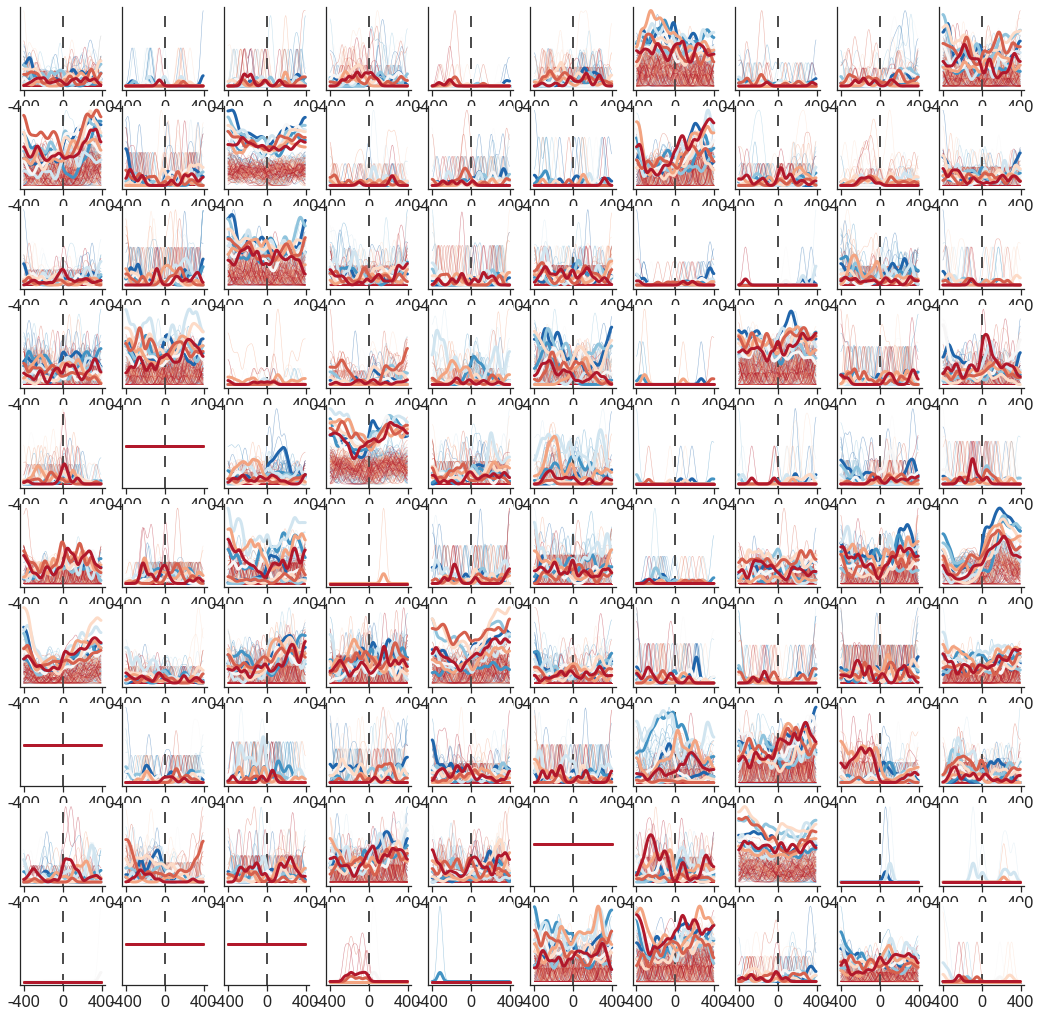

In [983]:
plt.figure(figsize=(18,18))
x = np.arange((window0 + window1)/150)

offset = 0
clrs_plot = seaborn.color_palette('RdBu_r',n_colors=9)
for ctr,neuron in enumerate(np.where(ccs_within>.7)[0]):
    plt.subplot(10,10,ctr+1)
    for poke_nr in range(9):
        activity = np.array(all_resps_g1_single_trial[offset+neuron][poke_nr])
        if len(activity)>0:
            for single_trial_activity in activity:
                single_trial_activity = gaussian_filter1d(single_trial_activity.reshape(-1,150).mean(axis=1),5)
                plt.plot(x/200,single_trial_activity,color=clrs_plot[poke_nr],linewidth=.5,alpha=.5)

            mean_activity = np.mean(activity,axis=0)
            mean_activity = gaussian_filter1d(mean_activity.reshape(-1,150).mean(axis=1),5)
            plt.plot(x/200,mean_activity*3,color=clrs_plot[poke_nr],linewidth=3,zorder=100)
            plt.axvline(x=window0/150/200,color='.3',dashes=(7,7))
            seaborn.despine()
            plt.xticks([0,.4,.8],[-400,0,400])
            plt.yticks([])
plt.tight_layout()